In [11]:
import yfinance as yf

# Download Apple data
apple_data = yf.download('AAPL', start='2015-01-01', end='2023-12-31')
print(apple_data.head())


[*********************100%***********************]  1 of 1 completed

Price                      Adj Close      Close       High        Low  \
Ticker                          AAPL       AAPL       AAPL       AAPL   
Date                                                                    
2015-01-02 00:00:00+00:00  24.347170  27.332500  27.860001  26.837500   
2015-01-05 00:00:00+00:00  23.661270  26.562500  27.162500  26.352501   
2015-01-06 00:00:00+00:00  23.663504  26.565001  26.857500  26.157499   
2015-01-07 00:00:00+00:00  23.995317  26.937500  27.049999  26.674999   
2015-01-08 00:00:00+00:00  24.917271  27.972500  28.037500  27.174999   

Price                           Open     Volume  
Ticker                          AAPL       AAPL  
Date                                             
2015-01-02 00:00:00+00:00  27.847500  212818400  
2015-01-05 00:00:00+00:00  27.072500  257142000  
2015-01-06 00:00:00+00:00  26.635000  263188400  
2015-01-07 00:00:00+00:00  26.799999  160423600  
2015-01-08 00:00:00+00:00  27.307501  237458000  


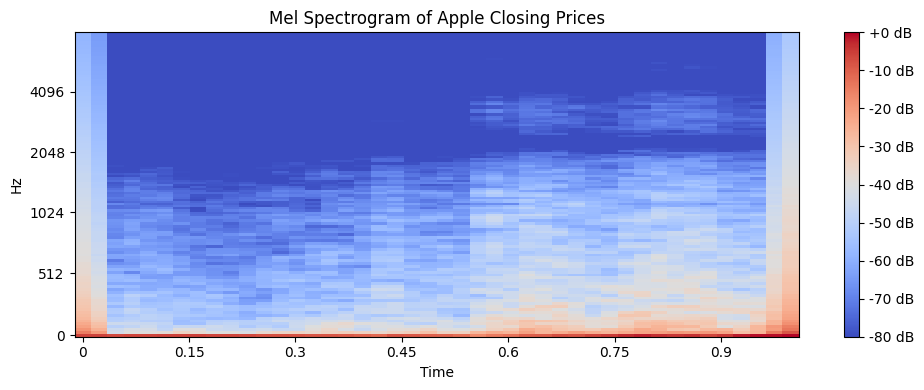

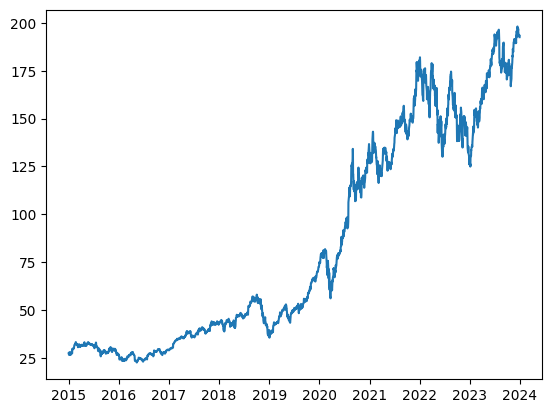

In [13]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Example data: Simulate `apple_data` with closing prices
# apple_data = pd.DataFrame({"Close": [some_values]})
closing_prices = apple_data['Close'].values

# Normalize the closing prices
normalized_prices = (closing_prices - np.mean(closing_prices)) / np.std(closing_prices)

# Ensure normalized_prices is a flat array
normalized_prices = np.asarray(normalized_prices).flatten()

# Create a time-domain signal by resampling/interpolating
desired_length = 22050  # Target length for 1 second of data
signal = np.interp(
    np.linspace(0, len(normalized_prices) - 1, desired_length),
    np.arange(len(normalized_prices)),
    normalized_prices
)

# Generate a mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=22050, n_mels=128, fmax=8000)

# Convert to decibels
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Display the mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=22050, x_axis='time', y_axis='mel', fmax=8000, cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram of Apple Closing Prices')
plt.tight_layout()
%matplotlib inline
plt.show()

plt.plot(apple_data['Close'])
plt.show()



## Functions

In [31]:
from statsmodels.distributions.empirical_distribution import ECDF

def large_volatility_probability(data, threshold=0.05):
    """
    Computes the probability of a large volatile day given past data.

    @param data: np.ndarray
        The percentage change or volatility data.
    @param threshold: float
        The threshold for considering a day "large volatile" (e.g., 0.05 for 5%).

    @return: float
        Probability of exceeding the threshold.
    """
    ecdf = ECDF(data)
    return 1 - ecdf(threshold)  # Probability of exceeding the threshold


In [24]:
def spectral_contrast_anomaly(data, sr=1, fmin=0.01, n_bands=3):
    """
    Computes a scalar representation of spectral contrast to detect anomalies.

    @param data: np.ndarray
        The preprocessed financial data.
    @param sr: int
        Sampling rate for the data.
    @param fmin: float
        Minimum frequency for spectral contrast.
    @param n_bands: int
        Number of frequency bands.

    @return: float
        Variance of spectral contrast across all bands and frames.
    """
    contrast = librosa.feature.spectral_contrast(y=data, sr=sr, fmin=fmin, n_bands=n_bands)
    return np.var(contrast)


In [18]:
import numpy as np
import pandas as pd
import librosa

def preprocess_financial_data(df, column='Close', method='pct_change', fillna=True):
    """
    Preprocesses a financial dataset into a format suitable for feature extraction.

    @param df: pd.DataFrame
        A Pandas DataFrame loaded with yfinance or similar financial data.
    @param column: str
        The column name in the DataFrame to process (e.g., 'Close', 'Adj Close').
    @param method: str
        Method for processing data:
        - 'pct_change': Calculate percentage changes (log returns).
        - 'raw': Use raw values from the specified column.
    @param fillna: bool
        Whether to fill missing values (NaNs) with 0.

    @return: np.ndarray
        A 1D array of the preprocessed financial data.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in the DataFrame.")
    
    if method == 'pct_change':
        data = df[column].pct_change().values
    elif method == 'raw':
        data = df[column].values
    else:
        raise ValueError("Unsupported method. Use 'pct_change' or 'raw'.")
    
    if fillna:
        data = np.nan_to_num(data)  # Replace NaN with 0

    return data.flatten()


def calculate_moving_average(data, window=14):
    """
    Calculates a moving average over the financial data.

    @param data: np.ndarray
        The preprocessed financial data (1D array).
    @param window: int
        The window size for calculating the moving average.

    @return: np.ndarray
        A 1D array of moving average values.
    """
    return np.convolve(data, np.ones(window) / window, mode='valid')


def calculate_volatility(data, window=14):
    """
    Calculates the rolling volatility (standard deviation) of financial data.

    @param data: np.ndarray
        The preprocessed financial data (1D array).
    @param window: int
        The window size for calculating rolling volatility.

    @return: np.ndarray
        A 1D array of volatility values.
    """
    return pd.Series(data).rolling(window).std().fillna(0).values


def calculate_spectral_centroid(data, sr=1):
    """
    Computes the spectral centroid of the financial data treated as a signal.

    @param data: np.ndarray
        The preprocessed financial data (1D array).
    @param sr: int
        The "sampling rate" for financial data (default is 1, as data points are indexed by time).

    @return: np.ndarray
        A 1D array of spectral centroid values.
    """
    return librosa.feature.spectral_centroid(y=data, sr=sr).flatten()


def calculate_zero_crossing_rate(data):
    """
    Computes the zero-crossing rate of the financial data.

    @param data: np.ndarray
        The preprocessed financial data (1D array).

    @return: np.ndarray
        A 1D array of zero-crossing rate values.
    """
    return librosa.feature.zero_crossing_rate(y=data).flatten()


def calculate_spectral_contrast(data, sr=1, fmin=0.01, n_bands=3):
    """
    Computes the spectral contrast of the financial data.

    @param data: np.ndarray
        The preprocessed financial data (1D array).
    @param sr: int
        The "sampling rate" for financial data.
    @param fmin: float
        The minimum frequency to consider for spectral contrast.
    @param n_bands: int
        The number of frequency bands.

    @return: np.ndarray
        A 2D array of spectral contrast values (n_bands + 1, time_frames).
    """
    return librosa.feature.spectral_contrast(y=data, sr=sr, fmin=fmin, n_bands=n_bands)



def calculate_chroma_features(data, sr=1):
    """
    Computes chroma features for the financial data treated as a signal.

    @param data: np.ndarray
        The preprocessed financial data (1D array).
    @param sr: int
        The "sampling rate" for financial data.

    @return: np.ndarray
        A 2D array of chroma features (12, time_frames).
    """
    return librosa.feature.chroma_stft(y=data, sr=sr)


def calculate_shannon_entropy(data, bins=10):
    """
    Computes the Shannon entropy of the financial data.

    @param data: np.ndarray
        The preprocessed financial data (1D array).
    @param bins: int
        The number of bins for calculating the histogram.

    @return: float
        The Shannon entropy of the data.
    """
    hist, _ = np.histogram(data, bins=bins, density=True)
    hist = hist[hist > 0]  # Avoid log(0)
    return -np.sum(hist * np.log(hist))


In [15]:
import librosa
import numpy as np

def baseline_preprocessor(signal, sampling_rate=22050, target_duration=5):
    """
    Preprocesses the signal by trimming or padding it to a fixed duration and sampling rate.

    @param signal: np.ndarray
        The input signal (1D array).
    @param sampling_rate: int
        The target sampling rate for the signal.
    @param target_duration: int
        The desired duration of the signal in seconds.

    @return: np.ndarray
        A preprocessed signal of the desired length and sampling rate.
    """
    target_length = sampling_rate * target_duration
    if len(signal) > target_length:
        return signal[:target_length]
    elif len(signal) < target_length:
        return np.pad(signal, (0, target_length - len(signal)), mode='constant')
    return signal


def extract_mfcc(data, sr=22050, n_mfcc=13):
    """
    Extracts Mel-Frequency Cepstral Coefficients (MFCCs) from the audio data.

    @param data: np.ndarray
        The preprocessed audio signal.
    @param sr: int
        The sampling rate of the signal.
    @param n_mfcc: int
        The number of MFCC features to extract.

    @return: np.ndarray
        MFCCs matrix of shape (n_mfcc, time_frames).
    """
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)
    return mfccs


def extract_spectral_centroid(data, sr=22050):
    """
    Computes the spectral centroid of the audio signal.

    @param data: np.ndarray
        The preprocessed audio signal.
    @param sr: int
        The sampling rate of the signal.

    @return: np.ndarray
        Array of spectral centroid values over time.
    """
    centroid = librosa.feature.spectral_centroid(y=data, sr=sr)
    return centroid


def extract_zero_crossing_rate(data):
    """
    Computes the zero-crossing rate of the audio signal.

    @param data: np.ndarray
        The preprocessed audio signal.

    @return: np.ndarray
        Array of zero-crossing rate values over time.
    """
    zcr = librosa.feature.zero_crossing_rate(y=data)
    return zcr


def extract_chroma_features(data, sr=22050):
    """
    Computes the chroma feature matrix from the audio signal.

    @param data: np.ndarray
        The preprocessed audio signal.
    @param sr: int
        The sampling rate of the signal.

    @return: np.ndarray
        Chroma feature matrix of shape (12, time_frames).
    """
    chroma = librosa.feature.chroma_stft(y=data, sr=sr)
    return chroma


def extract_spectral_contrast(data, sr=22050):
    """
    Computes the spectral contrast of the audio signal.

    @param data: np.ndarray
        The preprocessed audio signal.
    @param sr: int
        The sampling rate of the signal.

    @return: np.ndarray
        Spectral contrast matrix of shape (n_bands + 1, time_frames).
    """
    contrast = librosa.feature.spectral_contrast(y=data, sr=sr)
    return contrast


## Integration

In [37]:
import yfinance as yf

# Download financial data
apple_data = yf.download('AAPL', start='2015-11-01', end='2023-12-31')

# Preprocess data (e.g., percentage change)
processed_data = preprocess_financial_data(apple_data, column='Close', method='pct_change')

# Calculate features
moving_avg = calculate_moving_average(processed_data, window=14)
volatility = calculate_volatility(processed_data, window=14)
spectral_centroid = calculate_spectral_centroid(processed_data)
spectral_contrast = calculate_spectral_contrast(processed_data)
chroma = calculate_chroma_features(processed_data)
entropy = calculate_shannon_entropy(processed_data)

anomaly_score = spectral_contrast_anomaly(processed_data)

print(anomaly_score)

probability = large_volatility_probability(processed_data)

print(probability)



[*********************100%***********************]  1 of 1 completed

7.29460395886831
0.010223953261927932



C:\Users\islam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


[*********************100%***********************]  1 of 1 completed


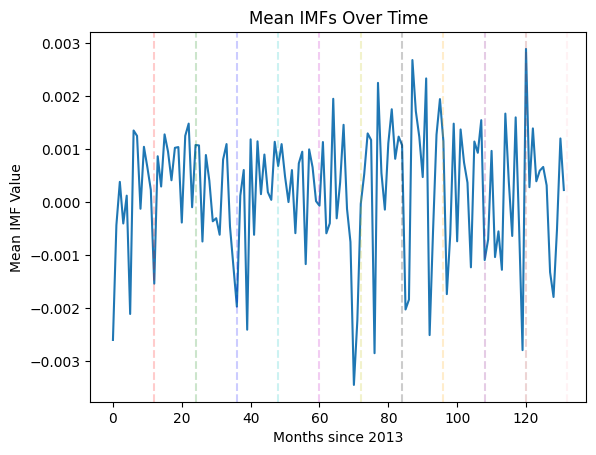

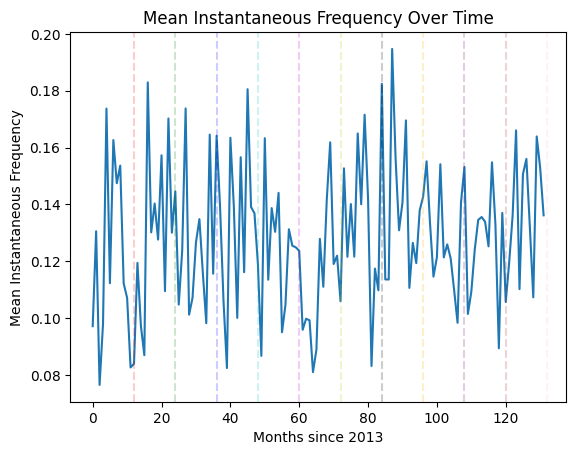

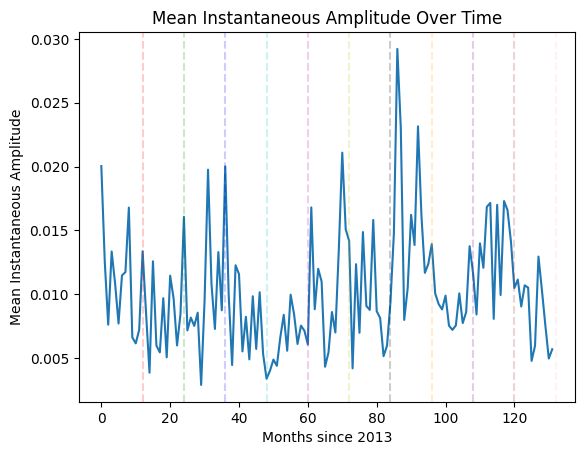

In [33]:
import numpy as np
import pandas as pd
from PyEMD import EMD
from scipy.signal import hilbert
import yfinance as yf

def preprocess_financial_data(df, column='Close', method='pct_change', fillna=True):
    """
    Preprocesses financial data to a format suitable for HHT analysis.

    @param df: pd.DataFrame
        The input financial data.
    @param column: str
        The column to analyze (e.g., 'Close').
    @param method: str
        Method for processing the data ('pct_change' or 'raw').
    @param fillna: bool
        Whether to fill NaN values.

    @return: np.ndarray
        Preprocessed 1D array of financial data.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")
    
    if method == 'pct_change':
        data = df[column].pct_change().values
    elif method == 'raw':
        data = df[column].values
    else:
        raise ValueError("Method must be 'pct_change' or 'raw'.")
    
    if fillna:
        data = np.nan_to_num(data)  # Fill NaNs with 0

    return data.flatten()

def hilbert_huang_transform(data):
    """
    Performs HHT on the given financial data.

    @param data: np.ndarray
        The input 1D financial time series data.

    @return: dict
        Dictionary containing IMFs, instantaneous frequencies, and amplitudes:
        - 'imfs': np.ndarray of shape (num_imfs, len(data))
        - 'instantaneous_freq': np.ndarray of shape (num_imfs, len(data))
        - 'instantaneous_amp': np.ndarray of shape (num_imfs, len(data))
    """
    # Decompose data using EMD
    emd = EMD()
    imfs = emd.emd(data)

    # Apply Hilbert Transform to each IMF
    instantaneous_freq = []
    instantaneous_amp = []
    for imf in imfs:
        analytic_signal = hilbert(imf)
        instantaneous_amp.append(np.abs(analytic_signal))  # Amplitude
        instantaneous_freq.append(np.diff(np.unwrap(np.angle(analytic_signal))) / (2.0 * np.pi))

    # Convert lists to arrays
    instantaneous_amp = np.array(instantaneous_amp)
    instantaneous_freq = np.array(instantaneous_freq)

    return {
        "imfs": imfs,
        "instantaneous_freq": instantaneous_freq,
        "instantaneous_amp": instantaneous_amp
    }

start_year = 2013
end_year = 2024

apple_data_all = yf.download('AAPL', start=f'{start_year}-01-01', end=f'{end_year}-12-31')

means = []
means_instantaneous_freq = []
means_instantaneous_amp = []

for year in range(start_year, end_year):
    # Example Usage
    for month in range(1, 13):
        # read data
        apple_data = apple_data_all[f'{year}-{month}-01':f'{year}-{month}-28']

        # Preprocess data
        processed_data = preprocess_financial_data(apple_data, column='Close', method='pct_change')

        # Perform HHT
        hht_results = hilbert_huang_transform(processed_data)

        # Extract results
        imfs = hht_results['imfs']
        instantaneous_freq = hht_results['instantaneous_freq']
        instantaneous_amp = hht_results['instantaneous_amp']

        means.append(np.mean(imfs))
        means_instantaneous_freq.append(np.mean(instantaneous_freq))
        means_instantaneous_amp.append(np.mean(instantaneous_amp))

import matplotlib.pyplot as plt

xs = range(len(means))

plt.plot(xs, means)
plt.title('Mean IMFs Over Time')
plt.xlabel('Months since 2013')
plt.ylabel('Mean IMF Value')
for year, color in zip(range(2014, 2025), ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink']):
    plt.axvline(x=(year - 2013) * 12, color=color, linestyle='--', alpha=0.2, label=str(year))
plt.show()

plt.plot(xs, means_instantaneous_freq)
plt.title('Mean Instantaneous Frequency Over Time')
plt.xlabel('Months since 2013')
plt.ylabel('Mean Instantaneous Frequency')
for year, color in zip(range(2014, 2025), ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink']):
    plt.axvline(x=(year - 2013) * 12, color=color, linestyle='--', alpha=0.2, label=str(year))
plt.show()

plt.plot(xs, means_instantaneous_amp)
plt.title('Mean Instantaneous Amplitude Over Time')
plt.xlabel('Months since 2013')
plt.ylabel('Mean Instantaneous Amplitude')
for year, color in zip(range(2014, 2025), ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink']):
    plt.axvline(x=(year - 2013) * 12, color=color, linestyle='--', alpha=0.2, label=str(year))
plt.show()


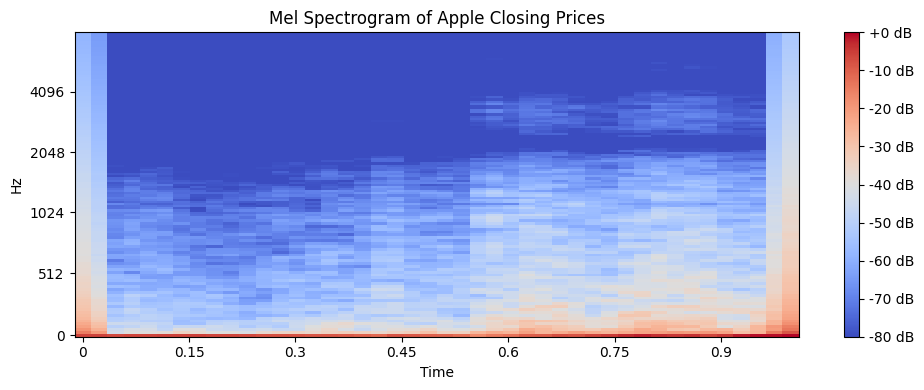

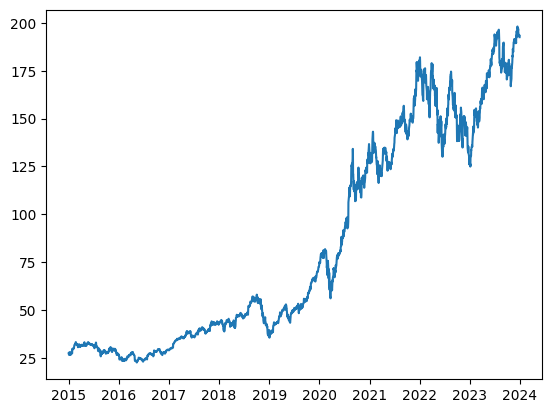

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Example data: Simulate `apple_data` with closing prices
# apple_data = pd.DataFrame({"Close": [some_values]})
closing_prices = apple_data['Close'].values

# Normalize the closing prices
normalized_prices = (closing_prices - np.mean(closing_prices)) / np.std(closing_prices)

# Ensure normalized_prices is a flat array
normalized_prices = np.asarray(normalized_prices).flatten()

# Create a time-domain signal by resampling/interpolating
desired_length = 22050  # Target length for 1 second of data
signal = np.interp(
    np.linspace(0, len(normalized_prices) - 1, desired_length),
    np.arange(len(normalized_prices)),
    normalized_prices
)

# Generate a mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=22050, n_mels=128, fmax=8000)

# Convert to decibels
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Display the mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=22050, x_axis='time', y_axis='mel', fmax=8000, cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram of Apple Closing Prices')
plt.tight_layout()
%matplotlib inline
plt.show()

plt.plot(apple_data['Close'])
plt.show()

